<a href="https://colab.research.google.com/github/Farmhouse121/Financial-Data-Science-in-Python/blob/main/Miscellaneous/Index_Pairwise_Correlations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Index Pairwise Correlations
---
### Initialize the Workspace
This is done by bringing in a standard library package, which you can find here [my_library.py](https://github.com/Farmhouse121/Financial-Data-Science-in-Python/blob/main/my_library.py). This needs to be imported into the workspace of the project, and then executed. For brevity, we also turn off `UserWarning` and `FutureWarning`. You can skip that step if you want to.

In [2]:
from my_library import *

13:37:02 Starting...
13:37:02 Installing yfinance into Google notebook...
13:37:06 Installing arch into Google notebook...
13:37:13 Initialized.


In [3]:
# let's ignore some warnings that clutter the output, skip this cell if you want to see them
from warnings import filterwarnings

for warning in UserWarning,FutureWarning:
    filterwarnings("ignore",category=warning)

### Load List of Index Members
---
This has been set up to allow you to select one of the known indices by setting that value for `indexname`. In the future, more indices might be added via similar code branches.

In [24]:
nprint("Getting members of %s index." % (indexname:='S&P MidCap 400')) # choose from 'S&P 500','NASDAQ-100','S&P MidCap 400'

if indexname=='S&P 500':
    display(index:=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0].rename(columns={"Symbol":"Ticker"}).set_index("Ticker"))
    first_date=index['Date added'].max() # add data is in table returned

elif indexname=='NASDAQ-100':
    display(index:=pd.read_html('https://en.wikipedia.org/wiki/Nasdaq-100')[4].set_index("Ticker"))
    first_date=datetime.now().strftime("%Y-01-02") # NASDAQ rebalances (normally) on the first day of the year. Jan'1st. is *always* a holiday

elif indexname=='S&P MidCap 400':
    display(index:=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_400_companies')[0].rename(columns={"Symbol":"Ticker"}).set_index("Ticker"))
    updates=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_400_companies')[1].set_index(("Date","Date"))
    updates.index=list(map(lambda x:pd.Period(x.split('[')[0],'D'),updates.index))
    first_date=str(updates.index.max())

else:
    raise ValueError("Don't know how to load members of %s Index!" % indexname)

nprint("First date for data extract is %s." % first_date)

13:45:32 Getting members of S&P MidCap 400 index.


,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,SEC filings
Ticker,,,,,
AA,Alcoa,Materials,Aluminum,"Pittsburgh, Pennsylvania",reports
AAON,AAON,Industrials,Building Products,"Tulsa, Oklahoma",reports
ACHC,Acadia Healthcare,Health Care,Health Care Facilities,"Franklin, Tennessee",reports
ACM,AECOM,Industrials,Construction & Engineering,"Dallas, Texas",reports
ADC,Agree Realty,Real Estate,Retail REITs,"Bloomfield Hills, Michigan",reports
...,...,...,...,...,...
XRAY,Dentsply Sirona,Health Care,Health Care Supplies,"Charlotte, North Carolina",reports
YETI,Yeti,Consumer Discretionary,Leisure Products,"Austin, Texas",reports
ZD,Ziff Davis,Communication Services,Advertising,"New York City, New York",reports


13:45:32 First date for data extract is 2024-07-26.


### Measure Correlations for a Random Sample of Index Member Pairs
---
This analysis is survivorship bias free because data is taken strictly from the last portfolio rebalance only.

In [25]:
results=pd.DataFrame({"Trial":list(range(N:=5000)),"Ticker 1":[""]*N,"Ticker 2":[""]*N,"Correlation":[np.nan]*N,"Sample":[np.nan]*N}).set_index("Trial")

nprint("Getting daily data for all index stocks, starting on {:s}.".format(first_date))
data=download(list(map(lambda x:x.replace(".","-"),index.index)),first_date)

for i in tqdm(results.index):
    df=data["Adj Close"].sample(2,axis=1)
    df.columns=pd.MultiIndex.from_product([["Adj Close"],df.columns])

    if df.shape[0]<10:
        continue

    for ticker in (tickers:=list(set(df.columns.get_level_values(1)))):
        df[('Return',ticker)]=df[('Adj Close',ticker)].pct_change()*hundred

    df.dropna(inplace=True)
    df.index=pd.DatetimeIndex(df.index).to_period('D')
    results.loc[i,"Ticker 1"]=tickers[0]
    results.loc[i,"Ticker 2"]=tickers[1]
    results.loc[i,"Correlation"]=df["Return"].corr().iloc[0,1]*hundred
    results.loc[i,"Sample"]=df.shape[0]

results.set_index(["Ticker 1","Ticker 2"],inplace=True)
results.loc["Mean","Sample"]=results.shape[0]
results.loc["Mean","Correlation"]=(m:=results["Correlation"].mean())
display(results)

13:45:37 Getting daily data for all index stocks, starting on 2024-07-26.


[*********************100%***********************]  401 of 401 completed


  0%|          | 0/5000 [00:00<?, ?it/s]

<ipython-input-25-395602f26453>:24: PerformanceWarning: indexing past lexsort depth may impact performance.
  results.loc["Mean","Sample"]=results.shape[0]
<ipython-input-25-395602f26453>:25: PerformanceWarning: indexing past lexsort depth may impact performance.
  results.loc["Mean","Correlation"]=(m:=results["Correlation"].mean())


,,Correlation,Sample
Ticker 1,Ticker 2,,
HGV,SMG,26.838558,35.0
ORI,OSK,36.225285,35.0
CRUS,AMH,-5.873105,35.0
NXT,BRX,23.397438,34.0
RYN,VLY,30.823497,35.0
...,...,...,...
SRPT,VAC,19.481186,35.0
M,MUSA,14.501572,35.0
FCFS,NVST,37.596158,35.0


### Make a Histogram

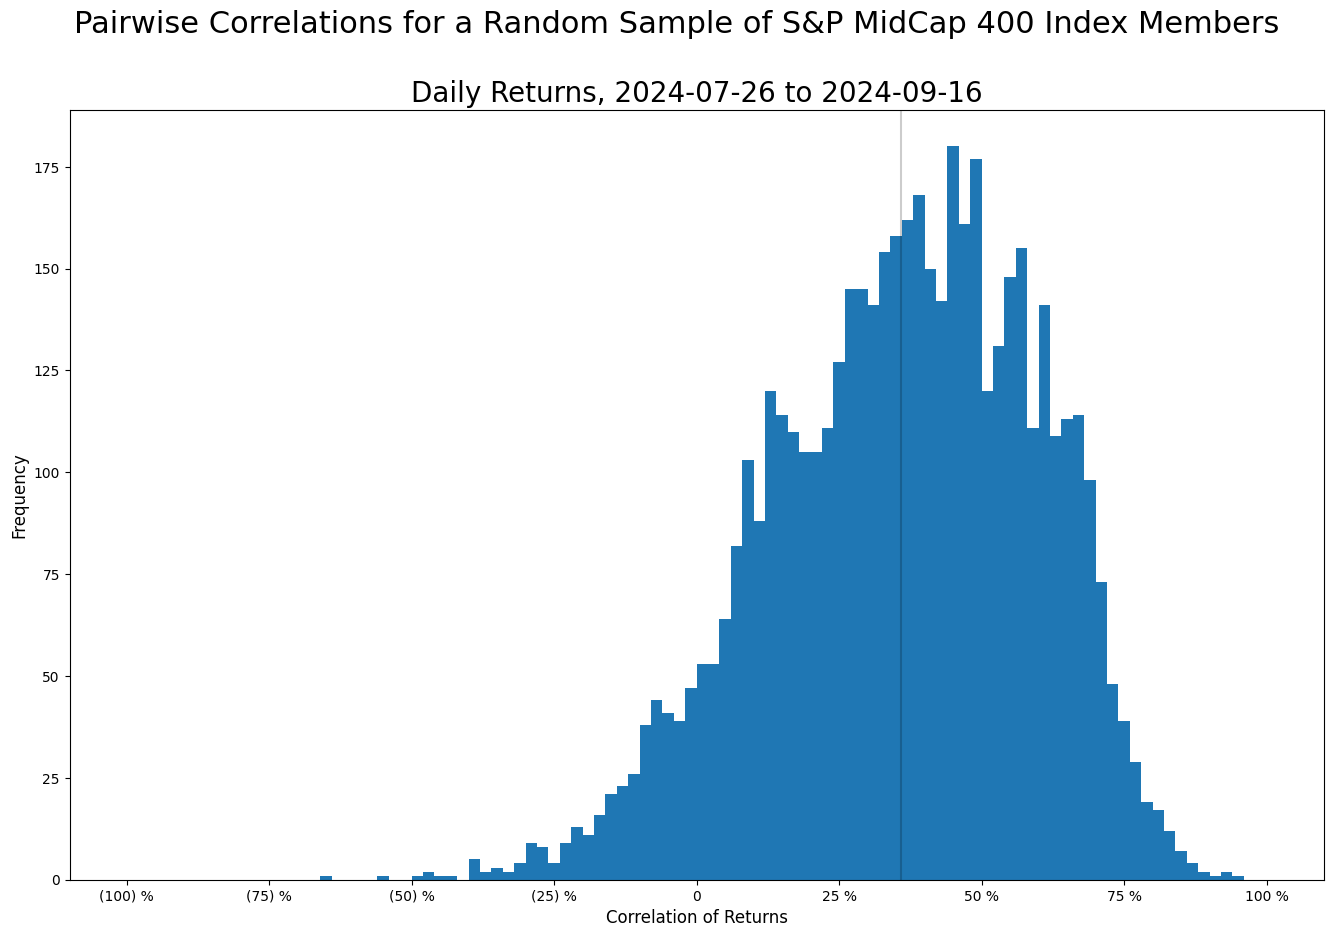

In [26]:
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
bins,counts,patches=plot.hist(results.loc[results.index!="Mean",'Correlation'].to_numpy(),bins=np.linspace(-hundred,hundred,101))
figure.suptitle(title:="Pairwise Correlations for a Random Sample of %s Index Members" % indexname,fontsize=22)
plot.set_title(subtitle:="Daily Returns, %s to %s" % (first_date,today("%Y-%m-%d")),fontsize=20)
plot.set_xlabel("Correlation of Returns",fontsize=12)
plot.xaxis.set_major_formatter(PercentLabels(0))
plot.set_ylabel("Frequency",fontsize=12)
plot.yaxis.set_major_formatter(CountLabels())
plot.axvline(m,color='black',alpha=0.2)
figure.savefig(title+".png",dpi=300,bbox_inches='tight')

### Execute the $N^*$ vs. $N$ Analysis
---
$N*$ is the effective degrees of freedom found within a portfolio of size $N$. This is computed by comparing the variance of the portfolio returns to the variance we would expect if all the stocks were independent.

In [27]:
results=pd.DataFrame({"Sample":range(1,(n:=1000)+1),"Assets":[np.nan]*n,"Portfolio":[np.nan]*n}).set_index("Sample") # n is number of trials
nprint("Getting daily data for all index stocks, starting on %s." % first_date)
closes=data['Adj Close']
closes.index=pd.DatetimeIndex(closes.index).to_period('B')

nprint("Beginning analysis for {:,d} trials. This may take about {:.1f} minutes...".format(n,n/2.38/60)) # approx empirical timings

for i in tqdm(results.index): # for each trial, pick a random sample of stocks with portfolio sizes uniformly distributed between 1 and maximum, one of 2^503-1 choices
    returns=pd.DataFrame()

    for ticker in closes[np.random.choice(closes.columns,np.random.randint(1,closes.shape[1]+1),replace=False)]:
        returns[ticker]=closes[ticker].pct_change().dropna()*hundred # compute all adjusted returns, ticker by ticker

        if returns[ticker].shape[0]<1: # exclude time-series that are all NA's
            returns.drop(columns=ticker,inplace=True)

        else:
            returns=returns.copy() # 'cos it frags, apparently

    results.loc[i,"Assets"]=returns.shape[1] # number of assets we ended up with
    results.loc[i,"Independent"]=returns.var().sum()/results.loc[i,"Assets"]**2 # if no correlation, portfolio variance is total variance divided by square of number of assets
    returns['Portfolio']=returns.mean(axis=1) # equal weighted portfolio return
    results.loc[i,"Portfolio"]=returns['Portfolio'].var() # variance of portfolio returns for same period as individual returns

results.dropna(inplace=True)
results["Effective D.o.F."]=results["Independent"]/results["Portfolio"]*results["Assets"]
display(results)
nprint("Done.")

13:48:51 Getting daily data for all index stocks, starting on 2024-07-26.
13:48:51 Beginning analysis for 1,000 trials. This may take about 7.0 minutes...


  0%|          | 0/1000 [00:00<?, ?it/s]

,Assets,Portfolio,Independent,Effective D.o.F.
Sample,,,,
1,327.0,1.721640,0.017343,3.293996
2,348.0,1.735367,0.016316,3.271818
3,387.0,1.718062,0.014943,3.365905
4,182.0,1.593412,0.027499,3.140942
5,254.0,1.703982,0.022402,3.339267
...,...,...,...,...
996,81.0,1.546448,0.067933,3.558183
997,85.0,2.080299,0.070987,2.900509
998,124.0,1.723905,0.047714,3.432024


13:53:44 Done.


### Make a Plot

13:55:53 Effective D.o.F. Limit 3.33, Implied Correlation 29.86 %.


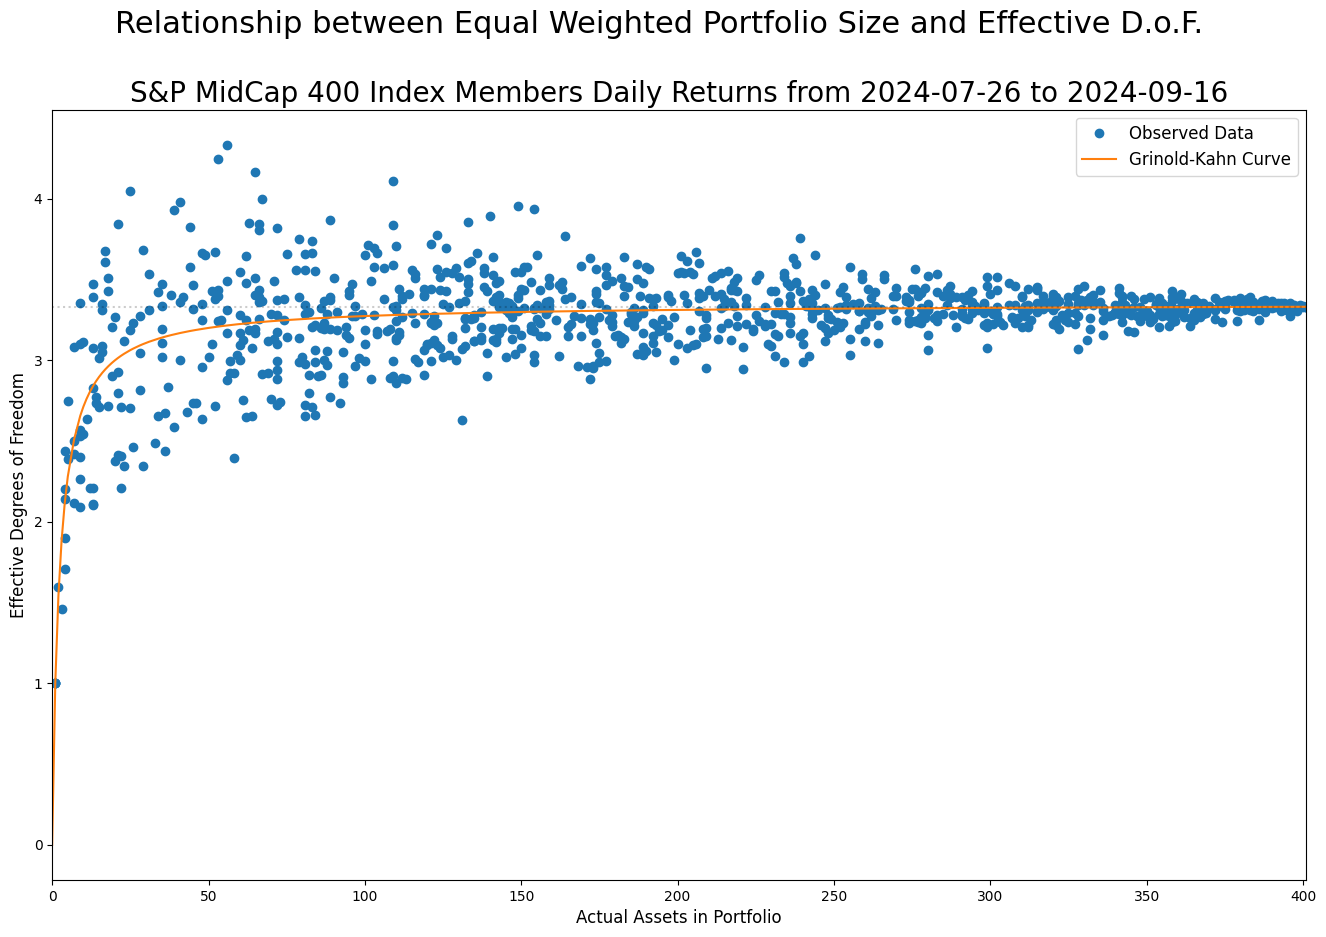

In [30]:
Nstar,Nact=tuple(results.sort_values("Assets").iloc[-1][["Effective D.o.F.","Assets"]])
rho=(Nact-Nstar)/((Nact-one)*Nstar)
nprint("Effective D.o.F. Limit {:,.2f}, Implied Correlation {:.2f} %.".format(Nstar,rho*hundred))

figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
plot.plot(x:=results["Assets"].to_numpy(),y:=results["Effective D.o.F."].to_numpy(),'o',label='Observed Data')
plot.plot(xp:=np.append([zero],np.unique(np.sort(x))),xp/(one+(xp-one)*rho),'-',label='Grinold-Kahn Curve')
plot.set_xlabel("Actual Assets in Portfolio",fontsize=12)
plot.set_ylabel("Effective Degrees of Freedom",fontsize=12)
figure.suptitle(title:="Relationship between Equal Weighted Portfolio Size and Effective D.o.F.",fontsize=22)
plot.set_title("%s Index Members Daily Returns from %s to %s" % (indexname,first_date,pd.Timestamp.today().strftime("%Y-%m-%d")),fontsize=20)
plot.set_xlim(zero,index.shape[0])
plot.legend(fontsize=12)
plot.axhline(Nstar,color='black',linestyle=':',alpha=0.2)
figure.savefig(title+".png",dpi=300,bbox_inches='tight')

### $\LaTeX$ Code for the Formulae in the Article

$$
V_P=\mathbb{V}\!\left[\frac{1}{N}\sum_{i=1}^Nr_{it}\right]=\frac{1}{N^2}\mathbb{V}\!\left[\sum_{i=1}^Nr_{it}\right]
$$

$$
V_P=\frac{1}{N^2}\sum_{i=1}^N\sigma_i^2+\frac{2}{N^2}\sum_{i=1}^N\sum_{j=i+1}^N\sigma_i\sigma_j\rho_{ij}=V_I+V_C
$$

$$
V_I=\frac{1}{N}\left(\frac{1}{N}\sum_{i=1}^N\sigma_i^2\right)=\frac{\overline{\sigma^2}}{N}
$$

$$
\mathbb{V}[\bar{x}]=\frac{\sigma^2}{N}\;\mathrm{where}\;\mathbb{V}[x_i]=\mathbb{V}[x_j]=\sigma^2\;\mathrm{and}\;\mathbb{C}[x_i,x_j]=0\;\forall\;i,j
$$

$$
V_P=V_I\left(1+\frac{V_C}{V_I}\right)=\frac{\overline{\sigma^2}}{N}\left(1+\frac{V_C}{V_I}\right)
$$

$$
V_P=\frac{\overline{\sigma^2}}{N^*}\;\mathrm{where}\;N^*=N\frac{V_I}{V_P}
$$

$$
\sum_{N=1}^M\begin{pmatrix}M\\ N\end{pmatrix}=2^M-1
$$

$$
2^{503}-1\approx3.3\times10^{150}
$$